<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/ChangePointDetection/notebooks/ChangePointDetection_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


#Change Point detection

**Links/ Reading**

[1] BEAST in an NDVI setting: http://www.biogeosphere.org/Publications/change-point-breakpoint-time-series-rbeast-landsat.pdf

[2] A survey of methdos for time sereis change point detection:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5464762/

**Offline/ online**

Change point detection algorithms are classically classified as:

>- **online**<br>
online, or real-time, algorithms run concurrently with the process they are monitoring, processing each data point as it becomes available, with a goal of detecting a change point as soon as possible after it occurs, ideally before the next data point arrives.


>- **offline**<br>
Offline algorithms consider the entire data set at once, and look back in time to recognize where the change occured.[2]

**Offline vs online**

The value of ε depends on the nature of the algorithm and amount of input data that is required for each step.

> Offline<br>


> Online<br>
Online algorithms process data within a sliding window with size n. For these approaches, n should be large enough to store the data that is necessary to represent the time series state yet small enough to still meet the epsilon requirement.


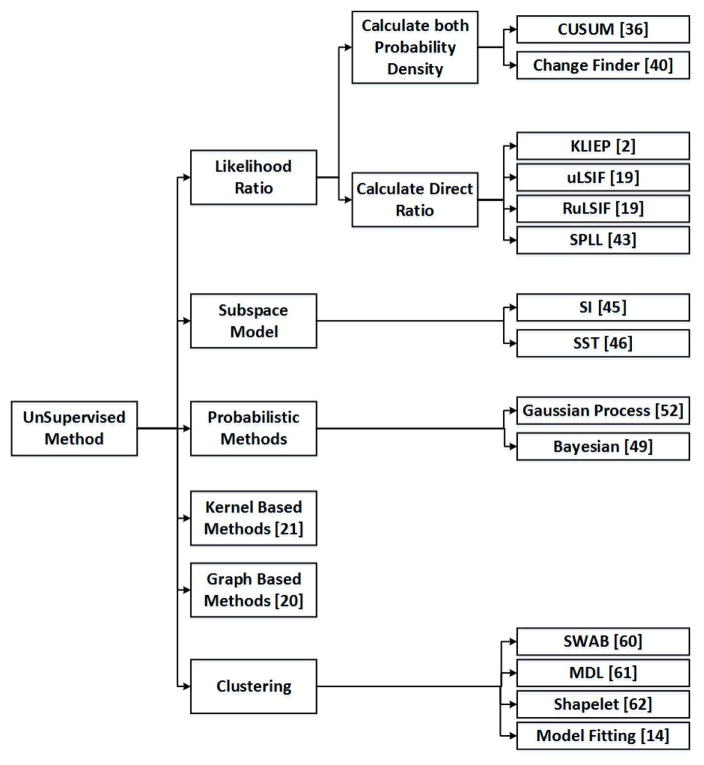


There is no comprehensive performance comparison among unsupervised methods, but it can be seen from experimental results that RulSIF consistently yields strong accuracy. Because kernel-based methods, subspace models, CUSUM, AR, and clustering methods rely upon parameters to model time series dynamics, they do not exhibit good performance for noisy data, or highly dynamic systems.

Comparisons that have been done for NDVI data
- CUSUM
- Bayesian
- GP

BEAST: Bayesian estimator of abrupt change, seasonality &
trend


# Bayesian Changepoint Detection

By hildensia: https://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb

In [ ]:
def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        
        # Evaluate the hazard function for this interval
        H = hazard_func(np.array(range(t+1)))
       
        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    
        maxes[t] = R[:, t].argmax()
    return R, maxes


def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)


class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_theta(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cProfile
from functools import partial
from scipy import stats
import pandas as pd


## create spoof data

In [ ]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [ ]:
data = generate_normal_time_series(7, 50, 200)

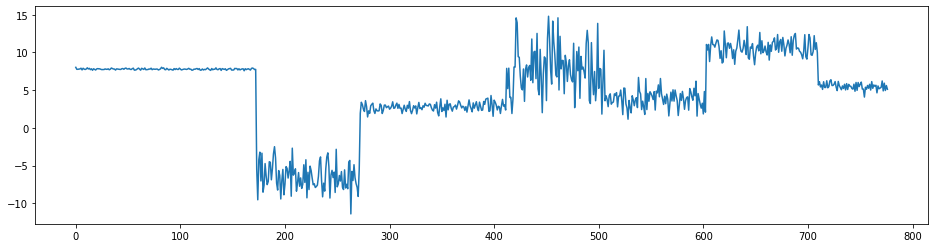

In [ ]:
fig, ax = plt.subplots(figsize=[16, 4])
ax.plot(data)

In [ ]:
R, maxes = online_changepoint_detection(data, partial(constant_hazard, 250), StudentT(0.1, .01, 1, 0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


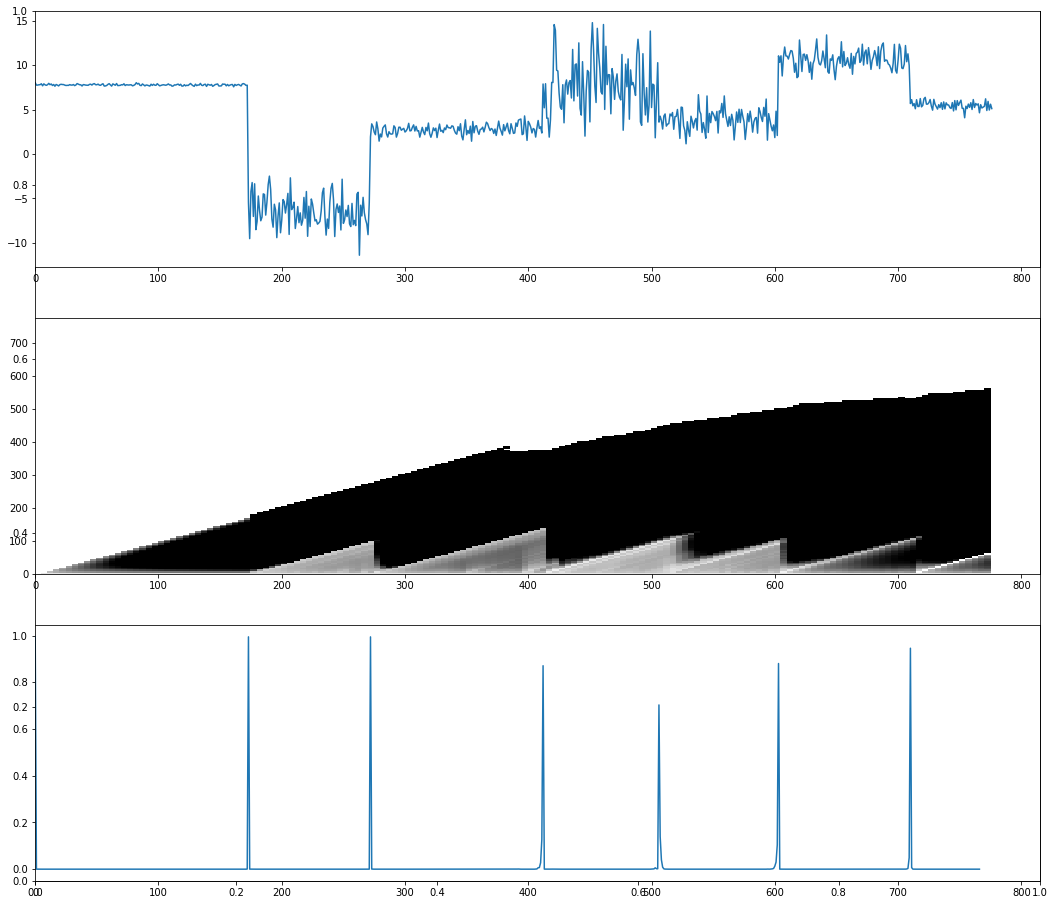

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

## test on SWFT345

In [ ]:
#variable declaration

filename = 'MODIS_TS_EVI_EBTRN_Sites.csv'

df = pd.read_csv(filename)
df.head()

,alt,lat,lon,siteID,2000-02-18T00:00:00,2000-03-05T00:00:00,2000-03-21T00:00:00,2000-04-06T00:00:00,2000-04-22T00:00:00,2000-05-08T00:00:00,2000-05-24T00:00:00,2000-06-09T00:00:00,2000-06-25T00:00:00,2000-07-11T00:00:00,2000-07-27T00:00:00,2000-08-12T00:00:00,2000-08-28T00:00:00,2000-09-13T00:00:00,2000-09-29T00:00:00,2000-10-15T00:00:00,2000-10-31T00:00:00,2000-11-16T00:00:00,2000-12-02T00:00:00,2000-12-18T00:00:00,2001-01-01T00:00:00,2001-01-17T00:00:00,2001-02-02T00:00:00,2001-02-18T00:00:00,2001-03-06T00:00:00,2001-03-22T00:00:00,2001-04-07T00:00:00,2001-04-23T00:00:00,2001-05-09T00:00:00,2001-05-25T00:00:00,2001-06-10T00:00:00,2001-06-26T00:00:00,2001-07-12T00:00:00,2001-07-28T00:00:00,2001-08-13T00:00:00,2001-08-29T00:00:00,...,2017-09-30T00:00:00,2017-10-16T00:00:00,2017-11-01T00:00:00,2017-11-17T00:00:00,2017-12-03T00:00:00,2017-12-19T00:00:00,2018-01-01T00:00:00,2018-01-17T00:00:00,2018-02-02T00:00:00,2018-02-18T00:00:00,2018-03-06T00:00:00,2018-03-22T00:00:00,2018-04-07T00:00:00,2018-04-23T00:00:00,2018-05-09T00:00:00,2018-05-25T00:00:00,2018-06-10T00:00:00,2018-06-26T00:00:00,2018-07-12T00:00:00,2018-07-28T00:00:00,2018-08-13T00:00:00,2018-08-29T00:00:00,2018-09-14T00:00:00,2018-09-30T00:00:00,2018-10-16T00:00:00,2018-11-01T00:00:00,2018-11-17T00:00:00,2018-12-03T00:00:00,2018-12-19T00:00:00,2019-01-01T00:00:00,2019-01-17T00:00:00,2019-02-02T00:00:00,2019-02-18T00:00:00,2019-03-06T00:00:00,2019-03-22T00:00:00,2019-04-07T00:00:00,2019-04-23T00:00:00,2019-05-09T00:00:00,2019-05-25T00:00:00,2019-06-10T00:00:00
0,570,47.191442,6.277375,FS25,2930.0,2741.0,2759.0,2965.0,3103.0,5839.0,8273.0,7278.0,6472.0,7109.0,5608.0,5141.0,5480.0,4829.0,4302.0,3244.0,2849.0,2668.0,2916.0,2505.0,2428.0,2400.0,2597.0,2624.0,1977.0,2663.0,3755.0,3486.0,4420.0,7553.0,6986.0,7317.0,6979.0,6763.0,5853.0,5968.0,...,4447.0,2906.0,2729.0,2549.0,2362.0,3701.0,2479.0,3277.0,2481.0,2496.0,2007.0,2793.0,3528.0,5065.0,5597.0,6332.0,6434.0,5359.0,5528.0,5590.0,5162.0,4246.0,4468.0,4286.0,3574.0,2759.0,2534.0,2552.0,2384.0,2384.0,1916.0,2360.0,2552.0,3249.0,2703.0,3325.0,3906.0,5072.0,6466.0,5616.0
1,325,48.509078,6.704715,FS54a,2824.0,2610.0,2864.0,2901.0,4854.0,4945.0,6032.0,5644.0,6037.0,6471.0,5714.0,5354.0,5014.0,5239.0,5525.0,4208.0,3529.0,3874.0,3216.0,3031.0,2745.0,2968.0,3014.0,3578.0,2581.0,3048.0,2454.0,4361.0,7437.0,6248.0,6190.0,6901.0,6974.0,6395.0,6089.0,882.0,...,5153.0,4080.0,4406.0,3477.0,4297.0,1802.0,2938.0,1378.0,3634.0,2730.0,3179.0,2805.0,5426.0,7028.0,7397.0,6904.0,6496.0,5874.0,6664.0,6411.0,5946.0,5241.0,5990.0,5808.0,4918.0,2975.0,2942.0,2702.0,1412.0,2183.0,2775.0,2807.0,2604.0,2898.0,2757.0,3235.0,5100.0,8108.0,7072.0,5839.0
2,145,49.205399,3.126344,FS02,2808.0,2217.0,2236.0,2437.0,6410.0,6248.0,6332.0,6522.0,6885.0,6287.0,6112.0,5450.0,5564.0,4777.0,5583.0,4151.0,2836.0,2738.0,2650.0,2459.0,1535.0,2636.0,2137.0,2586.0,1986.0,2219.0,2427.0,5080.0,6234.0,6934.0,7426.0,7114.0,5895.0,5966.0,6435.0,6920.0,...,4371.0,4510.0,3478.0,2693.0,2589.0,3040.0,2371.0,2472.0,1370.0,2759.0,2694.0,2769.0,4852.0,6524.0,6399.0,6447.0,6941.0,6019.0,5711.0,6083.0,5590.0,5059.0,4918.0,4748.0,4717.0,3868.0,2989.0,2851.0,2237.0,1804.0,2229.0,2286.0,2315.0,3084.0,2547.0,4822.0,5898.0,6292.0,6741.0,6262.0
3,138,49.323585,2.875263,FS60,2293.0,2116.0,2574.0,2546.0,6080.0,6194.0,6218.0,6225.0,6461.0,5913.0,5401.0,5374.0,5598.0,5245.0,5601.0,4309.0,3094.0,2431.0,2044.0,2465.0,2898.0,2373.0,2156.0,2561.0,1954.0,3151.0,2490.0,2844.0,6065.0,6993.0,7318.0,7031.0,5840.0,6025.0,6503.0,6868.0,...,4237.0,4227.0,3994.0,2713.0,2811.0,3810.0,2820.0,2556.0,1731.0,2765.0,2637.0,2782.0,4041.0,6251.0,6983.0,7085.0,6743.0,6344.0,5793.0,6124.0,5642.0,5266.0,5158.0,4823.0,5081.0,3571.0,2506.0,2921.0,2542.0,1702.0,2888.0,2338.0,2391.0,3307.0,2616.0,3540.0,6419.0,6285.0,6275.0,7015.0
4,87,55.605000,13.799000,FL,-235.0,2664.0,2397.0,2462.0,4790.0,4802.0,6462.0,5340.0,5997.0,5443.0,5636.0,2054.0,4396.0,4251.0,4614.0,1652.0,3576.0,1978.0,777.0,1986.0,2253.0,496.0,2236.0,2375.

In [ ]:
def reformat_modis_df(modis_df):
  modis_loc_df = modis_df.iloc[:,3:]
  modis_loc_df.index = modis_loc_df.iloc[:,0]
  modis_loc_df = modis_loc_df.iloc[:,1:]
  modis_loc_T = modis_loc_df.T
  modis_loc_T.index = pd.to_datetime(modis_loc_T.index)
  # modis_loc_T.plot(figsize=(25,10))

  # resample for monthly means
  modis_loc_T = modis_loc_T.resample('M').mean()

  ##GLDAS data retried from GEE sets the monthly avg on the first day of the month
  modis_loc_T.index = modis_loc_T.index.map(lambda t: t.replace(day=1))


  return(modis_loc_T)

mean_modis = reformat_modis_df(df)

In [ ]:
mean_modis

siteID,FS25,FS54a,FS02,FS60,FL,FR,Bnik,Bgar,Bcas,Bgov,Bdra,Bmon,Btjn,GERM174,GERM215,GERM151,ITAL039,ITAL036,SWIT259,SWIT345,SWIT295,s097,s033,s103,s106,E17,E45,E10,E09,E46,E06,E07,E39,E38,E31,E30,E50,E20,E18,E13,...,LLSR,OGMS,SSAK,WMFH,LR38,FS55,OAH,HSBB,HSKM,ITAL037,ROM_PAU,Bbuk,KA,E19,SAMA,OGLC,NGEW,KHKF,KHLF,KHLW,GERM184,GERM182,SeL,Ses,VERM11,VERM10,UnS,UnL,GERM148,GERM152,GERM167,GERM164,GERM212,GERM211,WHSB,WHSG,UK32,BWS,VERM19,VERM17
2000-02-01,2930.0,2824.0,2808.0,2293.0,-235.0,670.0,1729.0,3169.0,560.0,1466.0,1059.0,1888.0,1698.0,2749.0,-203.0,760.0,3512.0,3124.0,561.0,1748.0,2344.0,1987.0,2073.0,2232.0,2410.0,1267.0,3541.0,2558.0,2677.0,664.0,2393.0,2326.0,2757.0,2671.0,1997.0,2151.0,2583.0,2669.0,2851.0,2286.0,...,2264.0,1337.0,2562.0,2502.0,1635.0,2453.0,1825.0,1343.0,1731.0,2788.0,2494.0,2034.0,2166.0,3342.0,132.0,1844.0,1496.0,2375.0,2375.0,2375.0,2674.0,2674.0,-174.0,-174.0,1394.0,1394.0,230.0,230.0,1693.0,1693.0,786.0,786.0,2312.0,2312.0,2323.0,2323.0,2790.0,2790.0,94.0,94.0
2000-03-01,2750.0,2737.0,2226.5,2345.0,2530.5,2727.5,1935.0,2676.5,2501.0,1449.5,2294.0,1615.0,1699.5,2273.0,2369.5,1072.0,3892.5,3260.5,1486.0,1923.0,2480.0,1815.0,2511.5,2906.0,2249.5,2758.0,3683.0,2519.5,2797.0,2547.5,2497.0,2281.0,2266.0,2558.5,1694.5,2257.5,2931.0,1935.5,2845.5,2434.5,...,2593.5,658.0,1971.0,1845.0,1917.0,2412.0,3606.5,3009.5,1762.5,4432.5,1343.0,2498.0,2419.0,3034.0,1589.0,2435.0,1417.5,2638.0,2638.0,2638.0,2630.0,2630.0,2220.5,2220.5,1893.0,1893.0,2141.5,2141.5,2041.0,2041.0,1707.5,1707.5,2200.0,2200.0,2351.0,2351.0,4632.0,4632.0,606.0,606.0
2000-04-01,3034.0,3877.5,4423.5,4313.0,3626.0,3147.0,5193.0,6690.0,2938.0,5563.0,4505.0,2380.5,1783.5,1807.5,4156.0,2095.0,4729.5,4677.5,2207.0,3040.0,3733.5,4699.5,4904.5,3825.0,4098.0,3519.5,5163.0,2781.5,3744.5,2916.5,3941.5,3422.0,4387.0,4440.5,4294.0,2451.0,2650.5,3039.0,2642.5,3907.0,...,4110.5,1366.5,2797.5,2915.5,3854.5,4421.5,4520.5,2106.0,3950.5,5339.5,2569.0,6152.5,2515.0,3960.5,2940.5,2713.5,1931.0,3108.5,3108.5,3108.5,4045.0,4045.0,2821.5,2821.5,4599.0,4599.0,3609.0,3609.0,3357.5,3357.5,3911.5,3911.5,3002.5,3002.5,2802.5,2802.5,4008.5,4008.5,1998.5,1998.5
2000-05-01,7056.0,5488.5,6290.0,6206.0,5632.0,4475.5,7045.5,7676.5,6149.5,7363.5,7164.5,3784.5,4060.0,5611.5,4880.0,1814.0,5651.5,5094.5,6145.0,5774.5,6485.0,6059.5,7365.0,6359.5,5953.5,6791.0,6627.5,5591.5,6034.0,5815.5,6659.0,6712.5,6892.0,6621.0,7221.0,7299.0,3511.5,3511.5,3770.5,7097.5,...,5371.0,3069.0,5073.0,4892.0,7559.0,5969.5,5084.0,6023.5,6100.5,4930.0,5684.0,7637.5,6579.0,4405.5,5104.0,5095.0,3440.0,3410.0,3410.0,3410.0,5302.0,5302.0,3030.0,3030.0,7215.0,7215.0,4830.5,4830.5,5624.5,5624.5,6664.0,6664.0,4458.0,4458.0,4168.5,4168.5,5408.5,5408.5,3026.0,3026.0
2000-06-01,6875.0,5840.5,6703.5,6343.0,5668.5,5226.0,6523.5,7610.0,6100.0,7093.5,6391.5,5763.0,6268.5,5840.0,3756.0,1254.0,4926.5,6275.0,6256.0,6564.0,6440.0,7143.0,7657.0,6656.5,5683.0,5995.5,5212.0,5443.0,5345.0,6171.0,6751.5,6573.0,5459.5,6231.5,7050.5,7233.0,3457.0,5081.5,5452.0,6216.5,...,4880.0,3489.0,5106.0,5522.0,6960.0,6701.0,6548.5,5085.0,4246.5,5610.5,6502.5,6844.5,5872.5,5835.5,5105.0,5078.5,4229.5,3931.5,3931.5,3931.5,6395.0,6395.0,3001.5,3001.5,7564.5,7564.5,5130.0,5130.0,3612.0,3612.0,5288.0,5288.0,4299.5,4299.5,4477.5,4477.5,3231.5,3231.5,3894.0,3894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01,2456.0,2705.5,2300.5,2364.5,3162.0,2726.0,1910.0,2764.5,1117.5,1650.0,1198.5,2189.5,1146.0,2470.5,2110.5,-720.5,3278.0,1368.5,992.0,1853.5,1916.5,2240.0,2113.5,2755.0,2534.0,1298.5,3334.0,2548.0,2487.0,753.5,1872.0,2472.0,2564.0,2057.5,2158.5,2527.5,2955.5,2765.5,3664.0,2199.5,...,2381.5,1249.0,2898.0,2467.5,1697.5,2239.5,2676.5,1545.0,1990.5,1892.0,1305.

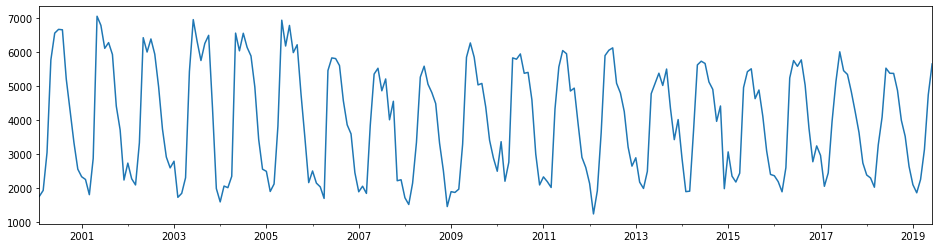

In [ ]:
mean_modis['SWIT345'].plot(figsize=(16,4))

In [ ]:
swit345 = mean_modis['SWIT345']
swit345 = swit345.reset_index()
data = np.array(swit345)[:,1]

In [ ]:
R, maxes = online_changepoint_detection(data, partial(constant_hazard, 250), StudentT(0.1, .01, 1, 0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


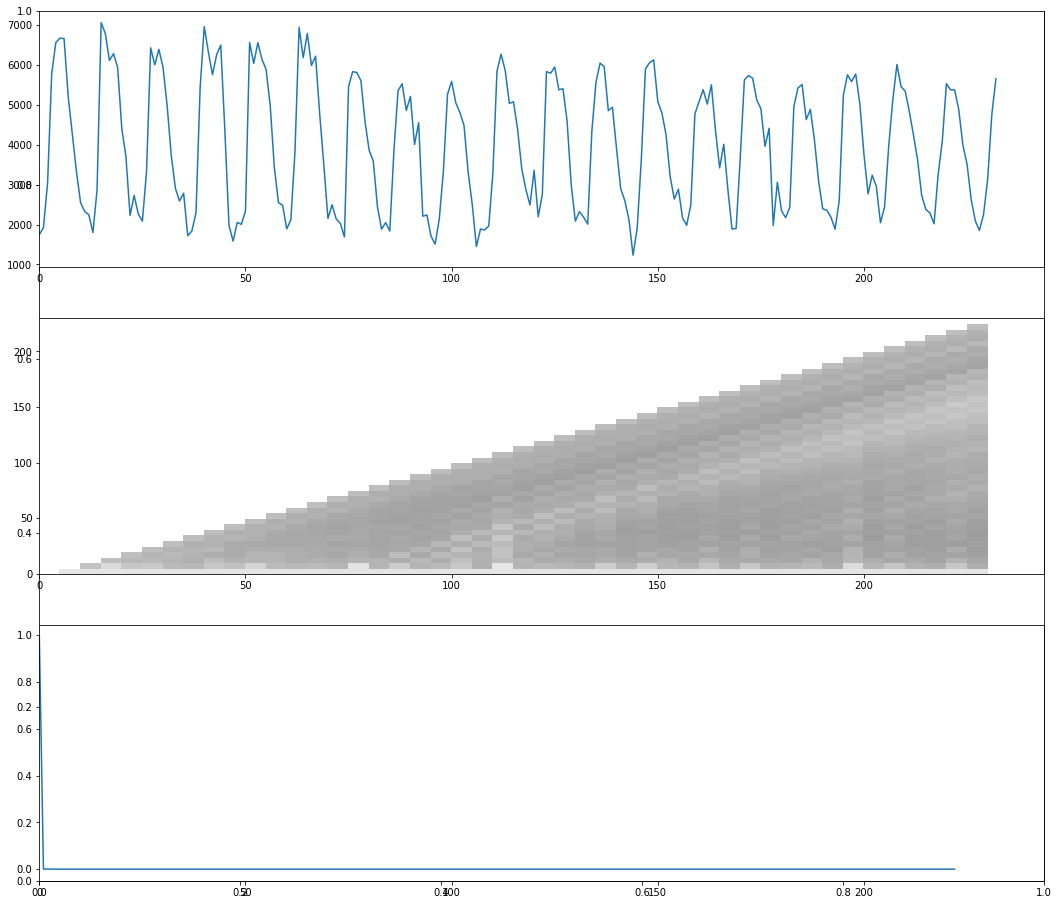

In [ ]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])